In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Exploratory Data Analysis

In [ ]:
import spacy

In [8]:
df = pd.read_csv("../Documents/Coding/ComplaintsData/Complaints-2022-Dataset.csv")

In [9]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/24/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,None,"EQUIFAX, INC.",FL,32258,None,Consent not provided,Web,08/24/22,Closed with explanation,Yes,NaN,5910626
1,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Someone has used my personal information to ob...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,IN,46260,None,Consent provided,Web,10/06/22,Closed with non-monetary relief,Yes,NaN,6056393
2,08/24/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,38135,None,Consent not provided,Web,08/24/22,Closed with non-monetary relief,Yes,NaN,5913937
3,10/06/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,My name is XXXX XXXX XXXX this complaint is no...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NY,13905,None,Consent provided,Web,10/06/22,Closed with explanation,Yes,NaN,6056396
4,10/10/22,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I took a road trip with my friend and we used ...,None,"EQUIFAX, INC.",CA,91752,None,Consent provided,Web,10/10/22,Closed with explanation,Yes,NaN,6068582


In [17]:
#Only including rows with a consumer complaint narrative and filtering to just 5000 rows
df = df.dropna(subset = 'Consumer complaint narrative')
df = df.sample(5000, random_state = 14)

In [18]:
#Columns in dataframe
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [19]:
#Checking data-types and null values for each feature of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 95331 to 588776
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 5000 non-null   object 
 1   Product                       5000 non-null   object 
 2   Sub-product                   5000 non-null   object 
 3   Issue                         5000 non-null   object 
 4   Sub-issue                     5000 non-null   object 
 5   Consumer complaint narrative  5000 non-null   object 
 6   Company public response       5000 non-null   object 
 7   Company                       5000 non-null   object 
 8   State                         5000 non-null   object 
 9   ZIP code                      5000 non-null   object 
 10  Tags                          5000 non-null   object 
 11  Consumer consent provided?    5000 non-null   object 
 12  Submitted via                 5000 non-null   object 
 1

## Dates the complaints were received versus sent

In [20]:
#Date complaint was sent does not always match date received 
sum(df['Date received'] == df['Date sent to company'])

4734

In [21]:
#There is not a clear pattern as to which dates were delayed in being sent by the CFPB to companies
df[~(df['Date received'] == df['Date sent to company'])][['Date received', 'Date sent to company']]

,Date received,Date sent to company
262323,04/22/22,05/10/22
262733,04/19/22,05/05/22
144235,01/27/22,02/14/22
589516,12/14/22,01/09/23
610212,11/30/22,12/21/22
...,...,...
625732,09/03/22,10/06/22
202774,03/13/22,04/14/22
3517,08/06/22,08/23/22
327136,10/12/22,10/27/22


In [22]:
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

In [23]:
df['Month sent to company'] = df['Date sent to company'].map(lambda x: x.month)

## Complaints visualized over time

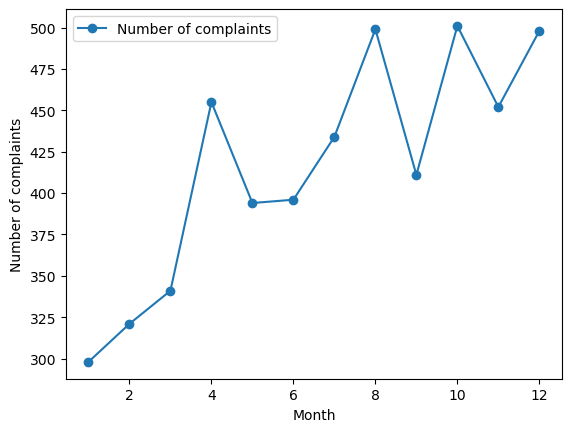

In [24]:
#Total number of complaints by month sent to company
plt.plot(df['Month sent to company'].value_counts().sort_index().index, df['Month sent to company'].value_counts().sort_index(), marker='o', linestyle='-', label='Number of complaints')
plt.xlabel('Month')
plt.ylabel('Number of complaints')
plt.legend(loc='best')
plt.show()

## Product/Sub-product Patterns 

<Axes: >

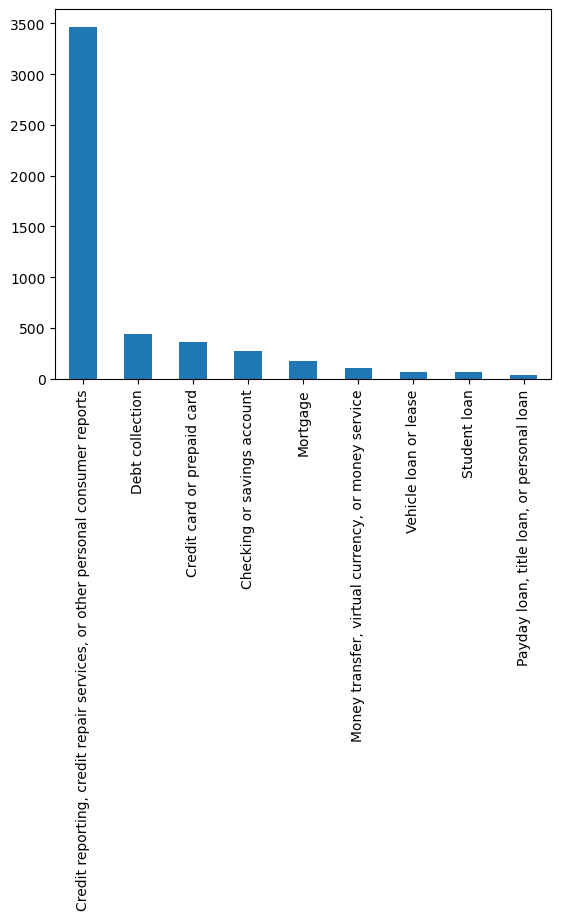

In [25]:
#Majority of complaints related to credit reporting/repair services/personal consumer reports
df['Product'].value_counts().plot(kind = 'bar')

In [26]:
#Number of each Product complaint by State
pivot_df = pd.pivot_table(data = df,
                         index = 'Product',
                         columns = 'State',
                         fill_value = 0,
                         aggfunc = 'count')
pivot_df

Company                 \
State                                                   AE AK  AL  AR  AZ   
Product                                                                     
Checking or savings account                              0  0   2   1   7   
Credit card or prepaid card                              0  0   2   3   8   
Credit reporting, credit repair services, or ot...       1  1  69  17  67   
Debt collection                                          0  0  15   4  12   
Money transfer, virtual currency, or money service       0  0   1   1   2   
Mortgage                                                 0  0   2   0   5   
Payday loan, title loan, or personal loan                0  0   2   0   0   
Student loan                                             0  0   1   2   2   
Vehicle loan or lease                                    0  0   0   1   4   

                                                                         ...  \
State                                                CA  CO  CT  DC  DE  ...   
Product                                                                  ...   
Checking or savings account                          37   5   7   2   3  ...   
Credit card or prepaid card                          44   6   4   3   2  ...   
Credit reporting, credit repair services, or ot...  335  19  24  14  22  ...   
Debt collection                                      39   4   2   0   1  ...   
Money transfer, virtual currency, or money service   13   0   1   0   1  ...   
Mortgage                                             26   3   2   1   1  ...   
Payday loan, title loan, or personal loan             3   2   0   0   0  ...   
Student loan                                          5   1   3   1   0  ...   
Vehicle loan or lease                                 3   0   3   0   1  ...   

                                                   ZIP code                  \
State                                                    SD  TN   TX UT  VA   
Product                                                                       
Checking or savings account                               0   4   17  2   9   
Credit card or prepaid card                               0   9   26  2  14   
Credit reporting, credit repair services, or ot...        2  62  365  9  95   
Debt collection                                           0   5   46  4   9   
Money transfer, virtual currency, or money service        0   2    8  0   3   
Mortgage                                                  0   3   14  2   6   
Payday loan, title loan, or personal loan                 0   1    3  0   1   
Student loan                                              0   3    6  2   1   
Vehicle loan or lease                                     0   3   10  0   2   

                                                                     
State                                              VT  WA  WI WV WY  
Product                                                              
Checking or savings account                         0   2   3  0  1  
Credit card or prepaid card                         1   7   5  0  1  
Credit reporting, credit repair services, or ot...  1  19  17  2  0  
Debt collection                                     0   1   4  1  1  
Money transfer, virtual currency, or money service  0   4   0  0  0  
Mortgage                                            1   4   1  0  1  
Payday loan, title loan, or personal loan           0   0   2  0  0  
Student loan                                        0   1   0  0  0  
Vehicle loan or lease                               1   0   0  0  0  

[9 rows x 918 columns]

In [27]:
#Highest Product Complaint by State
pivot_df.idxmax()

          State
Company   AE       Credit reporting, credit repair services, or o...
          AK       Credit reporting, credit repair services, or o...
          AL       Credit reporting, credit repair services, or o...
          AR       Credit reporting, credit repair services, or o...
          AZ       Credit reporting, credit repair services, or o...
                                         ...                        
ZIP code  VT                             Credit card or prepaid card
          WA       Credit reporting, credit repair services, or o...
          WI       Credit reporting, credit repair services, or o...
          WV       Credit reporting, credit repair services, or o...
          WY                             Checking or savings account
Length: 918, dtype: object

<Axes: >

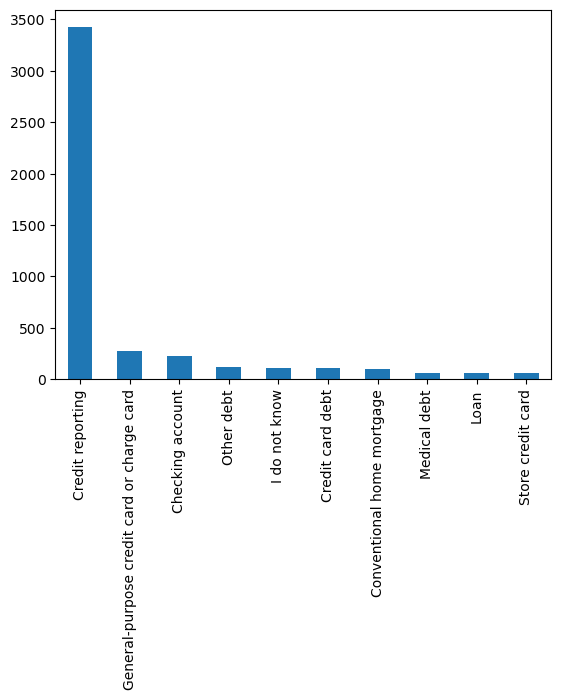

In [28]:
#Sub-product identified based on the product
df['Sub-product'].value_counts()[:10].plot(kind = 'bar')

In [29]:
#Number of each Sub-Product complaint by State
pivot2_df = pd.pivot_table(data = df,
                         index = 'Sub-product',
                         columns = 'State',
                         fill_value = 0,
                         aggfunc = 'count')
pivot2_df

Company                          \
State                                           AE AK  AL  AR  AZ   CA  CO   
Sub-product                                                                  
Auto debt                                        0  0   0   0   0    0   0   
CD (Certificate of Deposit)                      0  0   0   0   0    0   0   
Check cashing service                            0  0   0   0   0    1   0   
Checking account                                 0  0   1   1   7   31   4   
Conventional home mortgage                       0  0   1   0   2   17   2   
Credit card debt                                 0  0   0   0   3   12   0   
Credit repair services                           0  0   0   0   0    3   2   
Credit reporting                                 1  1  69  17  66  332  17   
Debt settlement                                  0  0   0   0   0    0   0   
Domestic (US) money transfer                     0  0   1   0   1    1   0   
FHA mortgage                                     0  0   1   0   2    3   0   
Federal student loan debt                        0  0   0   0   0    0   0   
Federal student loan servicing                   0  0   1   2   1    3   1   
Foreign currency exchange                        0  0   0   0   0    1   0   
General-purpose credit card or charge card       0  0   1   2   6   33   4   
General-purpose prepaid card                     0  0   0   1   0    1   0   
Gift card                                        0  0   0   0   0    1   0   
Government benefit card                          0  0   0   0   0    5   0   
Home equity loan or line of credit (HELOC)       0  0   0   0   0    2   0   
I do not know                                    0  0   2   0   4    8   3   
Installment loan                                 0  0   2   0   0    0   2   
International money transfer                     0  0   0   0   0    3   0   
Lease                                            0  0   0   0   0    0   0   
Loan                                             0  0   0   1   4    3   0   
Medical debt                                     0  0   4   1   2    1   1   
Mobile or digital wallet                         0  0   0   1   1    3   0   
Money order                                      0  0   0   0   0    0   0   
Mortgage debt                                    0  0   1   0   0    0   0   
Other banking product or service                 0  0   0   0   0    2   1   
Other debt                                       0  0   8   3   3   16   0   
Other personal consumer report                   0  0   0   0   1    0   0   
Other type of mortgage                           0  0   0   0   1    3   0   
Payday loan                                      0  0   0   0   0    2   0   
Payday loan debt                                 0  0   0   0   0    2   0   
Payroll card                                     0  0   0   0   0    0   1   
Personal line of credit                          0  0   0   0   0    1   0   
Private student loan                             0  0   0   0   1    2   0   
Private student loan debt                        0  0   0   0   0    0   0   
Refund anticipation check                        0  0   0   0   0    0   0   
Reverse mortgage                                 0  0   0   0   0    0   0   
Savings account                                  0  0   1   0   0    4   0   
Store credit card                                0  0   1   0   2    4   1   
Title loan                                       0  0   0   0   0    0   0   
Traveler's check or cashier's check              0  0   0   0   0    0   0   
VA mortgage                                      0  0   0   0   0    1   1   
Virtual currency                                 0  0   0   0   0    4   0   

                                                        ... ZIP code           \
State                                       CT  DC  DE  ...       SD  TN   TX   
Sub-product                                             ..

In [30]:
#Closely resembles Product pivot table
pivot2_df.idxmax()

          State
Company   AE       Credit reporting
          AK       Credit reporting
          AL       Credit reporting
          AR       Credit reporting
          AZ       Credit reporting
                         ...       
ZIP code  VT       Credit reporting
          WA       Credit reporting
          WI       Credit reporting
          WV       Credit reporting
          WY       Checking account
Length: 918, dtype: object

## Issue/Sub-issue Trends

<Axes: >

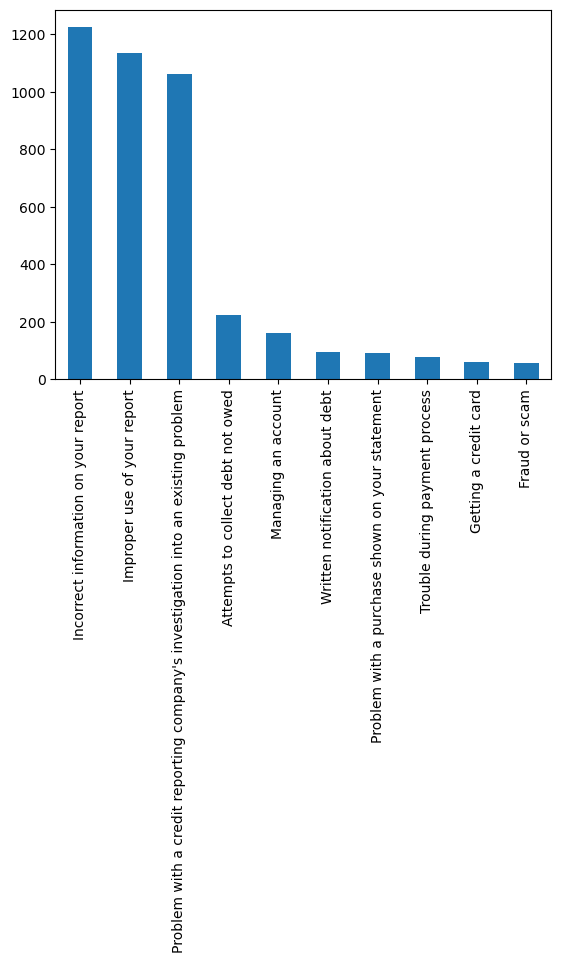

In [31]:
#Top 10 Issue complaints overall
df['Issue'].value_counts()[:10].plot(kind = 'bar')

In [32]:
#Number of complaints by Issue for each State
pivot3_df = pd.pivot_table(data = df,
                          index = 'Issue',
                          columns = 'State',
                          fill_value = 0,
                          aggfunc = 'count')
pivot3_df

Company                     \
State                                                   AE AK AL AR AZ  CA CO   
Issue                                                                           
Advertising and marketing, including promotiona...       0  0  0  1  0   3  0   
Applying for a mortgage or refinancing an exist...       0  0  0  0  2   6  0   
Attempts to collect debt not owed                        0  0  5  1  5  21  3   
Can't contact lender or servicer                         0  0  0  0  0   0  0   
Charged fees or interest you didn't expect               0  0  0  0  0   0  1   
...                                                    ... .. .. .. ..  .. ..   
Unexpected or other fees                                 0  0  0  1  0   2  0   
Vehicle was repossessed or sold the vehicle              0  0  0  0  0   0  0   
Was approved for a loan, but didn't receive money        0  0  0  0  0   0  0   
Written notification about debt                          0  0  4  2  3   8  1   
Wrong amount charged or received                         0  0  0  0  0   1  0   

                                                             ... ZIP code     \
State                                              CT DC DE  ...       SD TN   
Issue                                                        ...               
Advertising and marketing, including promotiona...  0  1  0  ...        0  0   
Applying for a mortgage or refinancing an exist...  0  0  1  ...        0  0   
Attempts to collect debt not owed                   1  0  1  ...        0  4   
Can't contact lender or servicer                    0  0  0  ...        0  0   
Charged fees or interest you didn't expect          0  0  0  ...        0  0   
...                                                .. .. ..  ...      ... ..   
Unexpected or other fees                            1  0  0  ...        0  0   
Vehicle was repossessed or sold the vehicle         0  0  0  ...        0  0   
Was approved for a loan, but didn't receive money   0  0  0  ...        0  0   
Written notification about debt                     0  0  0  ...        0  0   
Wrong amount charged or received                    0  0  0  ...        0  0   

                                                                             
State                                               TX UT VA VT WA WI WV WY  
Issue                                                                        
Advertising and marketing, including promotiona...   0  0  1  0  0  0  0  0  
Applying for a mortgage or refinancing an exist...   4  0  0  0  2  1  0  0  
Attempts to collect debt not owed                   23  3  5  0  0  1  0  0  
Can't contact lender or servicer                     0  0  0  0  0  1  0  0  
Charged fees or interest you didn't expect           0  0  1  0  0  0  0  0  
...                                                 .. .. .. .. .. .. .. ..  
Unexpected or other fees                             1  0  0  0  0  0  0  0  
Vehicle was repossessed or sold the vehicle          0  0  0  0  0  0  0  0  
Was approved for a loan, but didn't receive money    0  0  0  0  0  0  0  0  
Written notification about debt                     11  1  0  0  0  2  1  1  
Wrong amount charged or received                     0  0  0  0  0  0  0  0  

[65 rows x 918 columns]

In [33]:
#Most common Issue by State
pivot3_df.idxmax()

          State
Company   AE                    Incorrect information on your report
          AK       Problem with a credit reporting company's inve...
          AL                             Improper use of your report
          AR                             Improper use of your report
          AZ                    Incorrect information on your report
                                         ...                        
ZIP code  VT                                   Getting a credit card
          WA                             Improper use of your report
          WI                             Improper use of your report
          WV                             Improper use of your report
          WY                                     Managing an account
Length: 918, dtype: object

In [66]:
#Issues by company
pivot4_df = pd.pivot_table(data = df,
                          index = 'Issue',
                          columns = 'Company',
                          fill_value = 0,
                          aggfunc = 'count')
pivot4_df

Company public response  \
Company                                             A.R.M. Solutions, Inc.   
Issue                                                                        
Advertising and marketing, including promotiona...                       0   
Applying for a mortgage or refinancing an exist...                       0   
Attempts to collect debt not owed                                        1   
Can't contact lender or servicer                                         0   
Charged fees or interest you didn't expect                               0   
...                                                                    ...   
Unexpected or other fees                                                 0   
Vehicle was repossessed or sold the vehicle                              0   
Was approved for a loan, but didn't receive money                        0   
Written notification about debt                                          0   
Wrong amount charged or received                                         0   

                                                                      \
Company                                            ACIMA CREDIT, LLC   
Issue                                                                  
Advertising and marketing, including promotiona...                 0   
Applying for a mortgage or refinancing an exist...                 0   
Attempts to collect debt not owed                                  0   
Can't contact lender or servicer                                   0   
Charged fees or interest you didn't expect                         0   
...                                                              ...   
Unexpected or other fees                                           0   
Vehicle was repossessed or sold the vehicle                        0   
Was approved for a loan, but didn't receive money                  0   
Written notification about debt                                    2   
Wrong amount charged or received                                   0   

                                                                           \
Company                                            ADIR INTERNATIONAL LLC   
Issue                                                                       
Advertising and marketing, including promotiona...                      0   
Applying for a mortgage or refinancing an exist...                      0   
Attempts to collect debt not owed                                       0   
Can't contact lender or servicer                                        0   
Charged fees or interest you didn't expect                              0   
...                                                                   ...   
Unexpected or other fees                                                0   
Vehicle was repossessed or sold the vehicle                             0   
Was approved for a loan, but didn't receive money                       0   
Written notification about debt                                         0   
Wrong amount charged or received                                        0   

                                                                       \
Company                                            ADP Inc. AES/PHEAA   
Issue                                                                   
Advertising and marketing, including promotiona...        0         0   
Applying for a mortgage or refinancing an exist...        0         0   
Attempts to collect debt not owed                         0         0   
Can't contact lender or servicer                          0         0   
Charged fees or interest you didn't expect                0         0   
...                                                     ...       ...   
Unexpected or other fees                                  0         0   
Vehicle was repossessed or sold the vehicle               0         0   
Was approved for a loan, but didn't receive money         0        

In [67]:
#Top issue for each state
pivot4_df.idxmax()

                         Company                             
Company public response  A.R.M. Solutions, Inc.                                  Attempts to collect debt not owed
                         ACIMA CREDIT, LLC                                    Incorrect information on your report
                         ADIR INTERNATIONAL LLC                  Problem with a credit reporting company's inve...
                         ADP Inc.                                                           Trouble using the card
                         AES/PHEAA                                            Dealing with your lender or servicer
                                                                                       ...                        
ZIP code                 Winklevoss Exchange LLC                             Money was not available when promised
                         World Acceptance Corporation                           False statements or representation
                  

<Axes: >

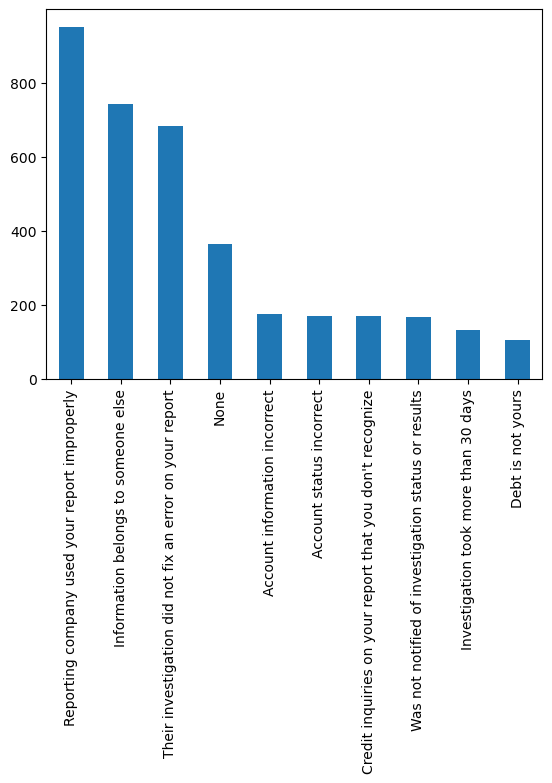

In [34]:
#Top 10 Sub-issues for overall complaints
df['Sub-issue'].value_counts()[:10].plot(kind = 'bar')

In [35]:
#Count of sub-issue for each state
pivot5_df = pd.pivot_table(data = df,
                          index = 'Sub-issue',
                          columns = 'State',
                          fill_value = 0,
                          aggfunc = 'count')
pivot5_df

Company                     \
State                                                   AE AK AL AR AZ  CA CO   
Sub-issue                                                                       
Account information incorrect                            1  0  3  1  8  19  2   
Account opened as a result of fraud                      0  0  0  0  0   3  1   
Account status incorrect                                 0  0  2  2  4  23  1   
Add-on products and services                             0  0  0  0  0   0  0   
Application denied                                       0  0  0  0  0   0  0   
...                                                    ... .. .. .. ..  .. ..   
Unexpected increase in interest rate                     0  0  0  0  0   0  0   
Used obscene, profane, or other abusive language         0  0  0  0  0   1  0   
Was not notified of investigation status or res...       0  0  4  0  3  11  1   
You never received your bill or did not know a ...       0  0  1  0  0   0  0   
You told them to stop contacting you, but they ...       0  0  0  0  1   0  0   

                                                             ... ZIP code     \
State                                              CT DC DE  ...       SD TN   
Sub-issue                                                    ...               
Account information incorrect                       3  0  3  ...        0  4   
Account opened as a result of fraud                 0  0  1  ...        0  0   
Account status incorrect                            1  1  1  ...        1  0   
Add-on products and services                        0  0  0  ...        0  0   
Application denied                                  0  0  0  ...        0  0   
...                                                .. .. ..  ...      ... ..   
Unexpected increase in interest rate                0  0  0  ...        0  0   
Used obscene, profane, or other abusive language    0  0  0  ...        0  0   
Was not notified of investigation status or res...  1  0  1  ...        0  8   
You never received your bill or did not know a ...  2  0  0  ...        0  0   
You told them to stop contacting you, but they ...  1  0  0  ...        0  0   

                                                                             
State                                               TX UT VA VT WA WI WV WY  
Sub-issue                                                                    
Account information incorrect                       15  0  2  0  2  3  0  0  
Account opened as a result of fraud                  4  0  1  0  0  0  0  0  
Account status incorrect                            20  0  3  0  1  0  0  0  
Add-on products and services                         0  0  0  0  1  0  0  0  
Application denied                                   1  0  0  0  0  0  0  0  
...                                                 .. .. .. .. .. .. .. ..  
Unexpected increase in interest rate                 0  0  0  0  0  1  0  0  
Used obscene, profane, or other abusive language     0  0  0  0  0  0  0  0  
Was not notified of investigation status or res...  17  0  1  0  1  0  0  0  
You never received your bill or did not know a ...   1  0  0  0  0  0  0  0  
You told them to stop contacting you, but they ...   0  0  0  0  0  1  0  0  

[134 rows x 918 columns]

In [36]:
#Top sub-issues by state
pivot5_df.idxmax()

          State
Company   AE                           Account information incorrect
          AK       Their investigation did not fix an error on yo...
          AL           Reporting company used your report improperly
          AR           Reporting company used your report improperly
          AZ           Reporting company used your report improperly
                                         ...                        
ZIP code  VT                                         Billing problem
          WA                                                    None
          WI           Reporting company used your report improperly
          WV           Reporting company used your report improperly
          WY                                         Cashing a check
Length: 918, dtype: object

## Company public response trends

<Axes: >

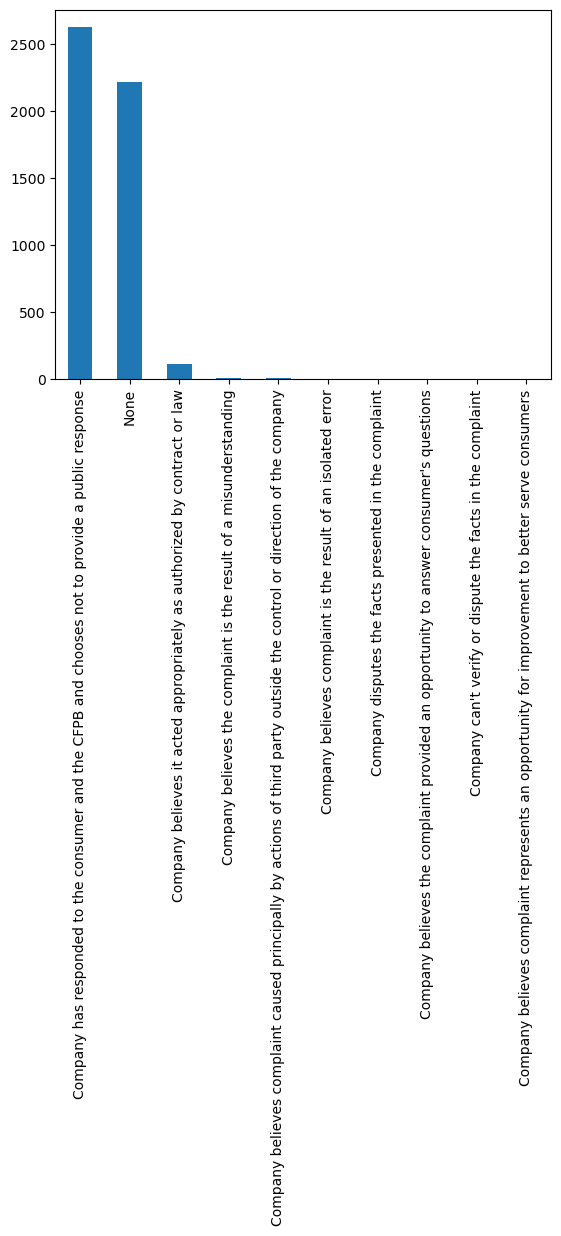

In [41]:
#Most common company public responses to customer complaints
df['Company public response'].value_counts()[:10].plot(kind = 'bar')

In [45]:
pivot6_df = pd.pivot_table(data = df,
              index = 'Company public response',
              columns = 'State',
              fill_value = 0,
              aggfunc = 'count')
pivot6_df

Company                 \
State                                                   AE AK  AL  AR  AZ   
Company public response                                                     
Company believes complaint caused principally b...       0  0   0   0   0   
Company believes complaint is the result of an ...       0  0   0   0   0   
Company believes complaint represents an opport...       0  0   0   0   0   
Company believes it acted appropriately as auth...       0  0   3   2   4   
Company believes the complaint is the result of...       0  0   0   0   0   
Company believes the complaint provided an oppo...       0  0   0   0   0   
Company can't verify or dispute the facts in th...       0  0   0   0   0   
Company disputes the facts presented in the com...       0  0   0   0   0   
Company has responded to the consumer and the C...       1  1  47  11  53   
None                                                     0  0  44  16  50   

                                                                         ...  \
State                                                CA  CO  CT  DC  DE  ...   
Company public response                                                  ...   
Company believes complaint caused principally b...    1   0   0   0   0  ...   
Company believes complaint is the result of an ...    0   0   0   0   0  ...   
Company believes complaint represents an opport...    0   0   0   0   0  ...   
Company believes it acted appropriately as auth...   10   1   1   0   0  ...   
Company believes the complaint is the result of...    0   0   0   0   0  ...   
Company believes the complaint provided an oppo...    1   0   0   0   0  ...   
Company can't verify or dispute the facts in th...    0   0   0   0   0  ...   
Company disputes the facts presented in the com...    1   0   0   0   0  ...   
Company has responded to the consumer and the C...  287  13  19  12  16  ...   
None                                                205  26  26   9  15  ...   

                                                   ZIP code                   \
State                                                    SD  TN   TX  UT  VA   
Company public response                                                        
Company believes complaint caused principally b...        0   0    0   0   0   
Company believes complaint is the result of an ...        0   0    1   0   1   
Company believes complaint represents an opport...        0   0    0   0   0   
Company believes it acted appropriately as auth...        0   3   10   4   3   
Company believes the complaint is the result of...        0   0    2   0   1   
Company believes the complaint provided an oppo...        0   0    0   0   1   
Company can't verify or dispute the facts in th...        0   0    1   0   0   
Company disputes the facts presented in the com...        0   0    1   0   0   
Company has responded to the consumer and the C...        2  44  271   6  76   
None                                                      0  45  209  11  58   

                                                                     
State                                              VT  WA  WI WV WY  
Company public response                                              
Company believes complaint caused principally b...  0   1   0  0  0  
Company believes complaint is the result of an ...  0   0   0  0  0  
Company believes complaint represents an opport...  0   0   0  0  0  
Company believes it acted appropriately as auth...  0   1   0  1  1  
Company believes the complaint is the result of...  0   0   0  0  0  
Company believes the complaint provided an oppo...  0   0   0  0  0  
Company can't verify or dispute the facts in th...  0   0   0  0  0  
Company disputes the facts presented in the com...  0   0   0  0  0  
Company has responded to the consumer and the C...  2  20  20  1  1  
None                                                2  16  12  1  2  

[10 rows x 918 columns]

In [46]:
#Top company responses by state
pivot5_df.idxmax()

          State
Company   AE       Company has responded to the consumer and the ...
          AK       Company has responded to the consumer and the ...
          AL       Company has responded to the consumer and the ...
          AR                                                    None
          AZ       Company has responded to the consumer and the ...
                                         ...                        
ZIP code  VT       Company has responded to the consumer and the ...
          WA       Company has responded to the consumer and the ...
          WI       Company has responded to the consumer and the ...
          WV       Company believes it acted appropriately as aut...
          WY                                                    None
Length: 918, dtype: object

## Timely response trends by company

In [64]:
#Proportion of timely responses for each company
pd.crosstab(df['Company'], df['Timely response?'], normalize = 'index')

Timely response?,No,Yes
Company,,
"A.R.M. Solutions, Inc.",0.0,1.0
"ACIMA CREDIT, LLC",0.0,1.0
ADIR INTERNATIONAL LLC,1.0,0.0
ADP Inc.,0.0,1.0
AES/PHEAA,0.0,1.0
...,...,...
Winklevoss Exchange LLC,0.0,1.0
World Acceptance Corporation,0.0,1.0
World Omni Financial Corp.,0.0,1.0
